# ***Room Occupancy Detection***






This Code is an implementation of Room Occupancy Detection Models, the classification goal is to detect whether a room is occupied (Occupied == 1) or not (Occupied == 0)


---
**Data Set Information**


*   Room Occupancy is decided by multiple features (Light, CO2, Temperature,
 and Humidity)
*   There are no missing values and extensixe data preprocessing will not be needed
*   Target Feature (Occupancy) will have to be resampled as there is a significant difference between the binary classes


---


**Algortihms Used**


1.   *Classification:*
      For the classification portion, SVM was used with a linear kernel
2.   *Time Series:*
      Bi-LSTM was the algorithm picked here.






# *Loading the necessary libraries and the data set*


In [ ]:
#Data Handling
import pandas as pd
import numpy as np
#Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Data Splitting and Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
#Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import resample
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_score
# Deep Learning Libraries
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Occupancy.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# *Data Exploration and Visualization*



In [ ]:
df.head()

,ID,Date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,140,02/02/2015 14:19,23.7000,26.272,585.200000,749.200000,0.004764,1
1,141,02/02/2015 14:19,23.7180,26.290,578.400000,760.400000,0.004773,1
2,142,02/02/2015 14:21,23.7300,26.230,572.666667,769.666667,0.004765,1
3,143,02/02/2015 14:22,23.7225,26.125,493.750000,774.750000,0.004744,1
4,144,02/02/2015 14:23,23.7540,26.200,488.600000,779.000000,0.004767,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2665 entries, 0 to 2664
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             2665 non-null   int64  
 1   Date           2665 non-null   object 
 2   Temperature    2665 non-null   float64
 3   Humidity       2665 non-null   float64
 4   Light          2665 non-null   float64
 5   CO2            2665 non-null   float64
 6   HumidityRatio  2665 non-null   float64
 7   Occupancy      2665 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 166.7+ KB


In [ ]:
df.describe()

,ID,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000
mean,1472.000000,21.433876,25.353937,193.227556,717.906470,0.004027,0.364728
std,769.463558,1.028024,2.436842,250.210906,292.681718,0.000611,0.481444
min,140.000000,20.200000,22.100000,0.000000,427.500000,0.003303,0.000000
25%,806.000000,20.650000,23.260000,0.000000,466.000000,0.003529,0.000000
50%,1472.000000,20.890000,25.000000,0.000000,580.500000,0.003815,0.000000
75%,2138.000000,22.356667,26.856667,442.500000,956.333333,0.004532,1.000000
max,2804.000000,24.408333,31.472500,1697.250000,1402.250000,0.005378,1.000000


In [ ]:
df['Occupancy'].value_counts()

Occupancy
0    1693
1     972
Name: count, dtype: int64

<Axes: ylabel='count'>

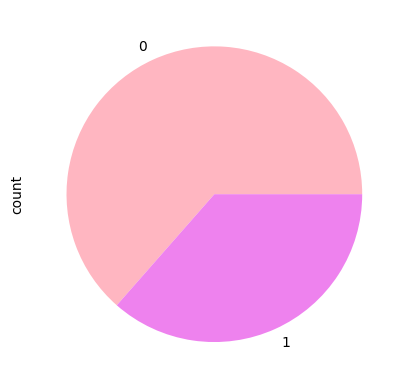

In [ ]:
# Check the distribution of the target variable
df['Occupancy'].value_counts().plot(kind="pie",colors=['lightpink', 'violet'])

In [ ]:
#Here, I've chosen to undersample instead of oversample, so I'll be downsampling by removing insantces of the majority class (Occupancy == 0)
df_majority = df[df['Occupancy'] == 0]
df_minority = df[df['Occupancy'] == 1]
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)

# Combine minority class with downsampled majority class
df_resampled = pd.concat([df_majority_downsampled, df_minority])

In [ ]:
# Undersample the majority class to balance the dataset
df_resampled['Occupancy'].value_counts()

Occupancy
0    972
1    972
Name: count, dtype: int64

<Axes: ylabel='count'>

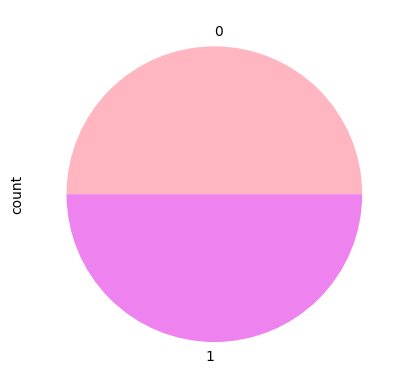

In [ ]:
# Verify the class distribution
df_resampled['Occupancy'].value_counts().plot(kind="pie", colors=['lightpink', 'violet'])

In [ ]:
df_resampled.head()

,ID,Date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
2065,2205,04/02/2015 00:43,20.810,24.9560,0.0,541.6,0.003789,0
2537,2677,04/02/2015 08:36,21.000,25.3900,444.0,718.0,0.003901,0
2358,2498,04/02/2015 05:37,20.625,24.4175,0.0,457.5,0.003665,0
1978,2118,03/02/2015 23:17,20.890,25.2000,0.0,561.4,0.003846,0
2176,2316,04/02/2015 02:35,20.700,25.0000,0.0,496.0,0.003770,0


In [ ]:
# Drop unnecessary columns
df_resampled = df_resampled.drop(columns=['ID', 'HumidityRatio'], axis=1)

In [ ]:
# Define features and target variable
X= df_resampled.drop(columns=['Date', 'Occupancy'], axis=1)
y= df_resampled['Occupancy']

In [ ]:
round(X.describe(),2)

,Temperature,Humidity,Light,CO2
count,1944.00,1944.00,1944.00,1944.00
mean,21.63,25.74,256.59,778.33
std,1.08,2.52,259.82,307.25
min,20.20,22.10,0.00,427.50
25%,20.70,24.05,0.00,475.67
50%,21.20,25.20,407.58,711.20
75%,22.70,27.56,461.33,1045.35
max,24.41,31.47,1697.25,1402.25


In [ ]:
data= df_resampled

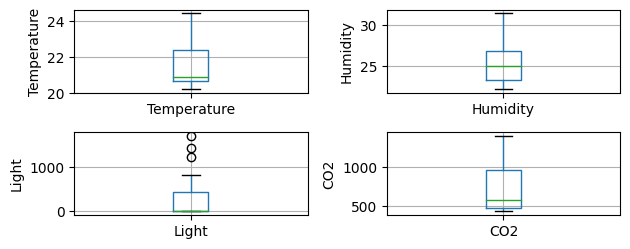

In [ ]:
# Box plots for each feature
plt.subplot(4, 2, 1)
fig = df.boxplot(column='Temperature')
fig.set_title('')
fig.set_ylabel('Temperature')

plt.subplot(4, 2, 2)
fig = df.boxplot(column='Humidity')
fig.set_title('')
fig.set_ylabel('Humidity')

plt.subplot(4, 2, 3)
fig = df.boxplot(column='Light')
fig.set_title('')
fig.set_ylabel('Light')

plt.subplot(4, 2, 4)
fig = df.boxplot(column='CO2')
fig.set_title('')
fig.set_ylabel('CO2')

plt.tight_layout()
plt.show()

In [ ]:
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)

Date           0
Temperature    0
Humidity       0
Light          0
CO2            0
Occupancy      0
dtype: int64


In [ ]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
sns.set_style('whitegrid')

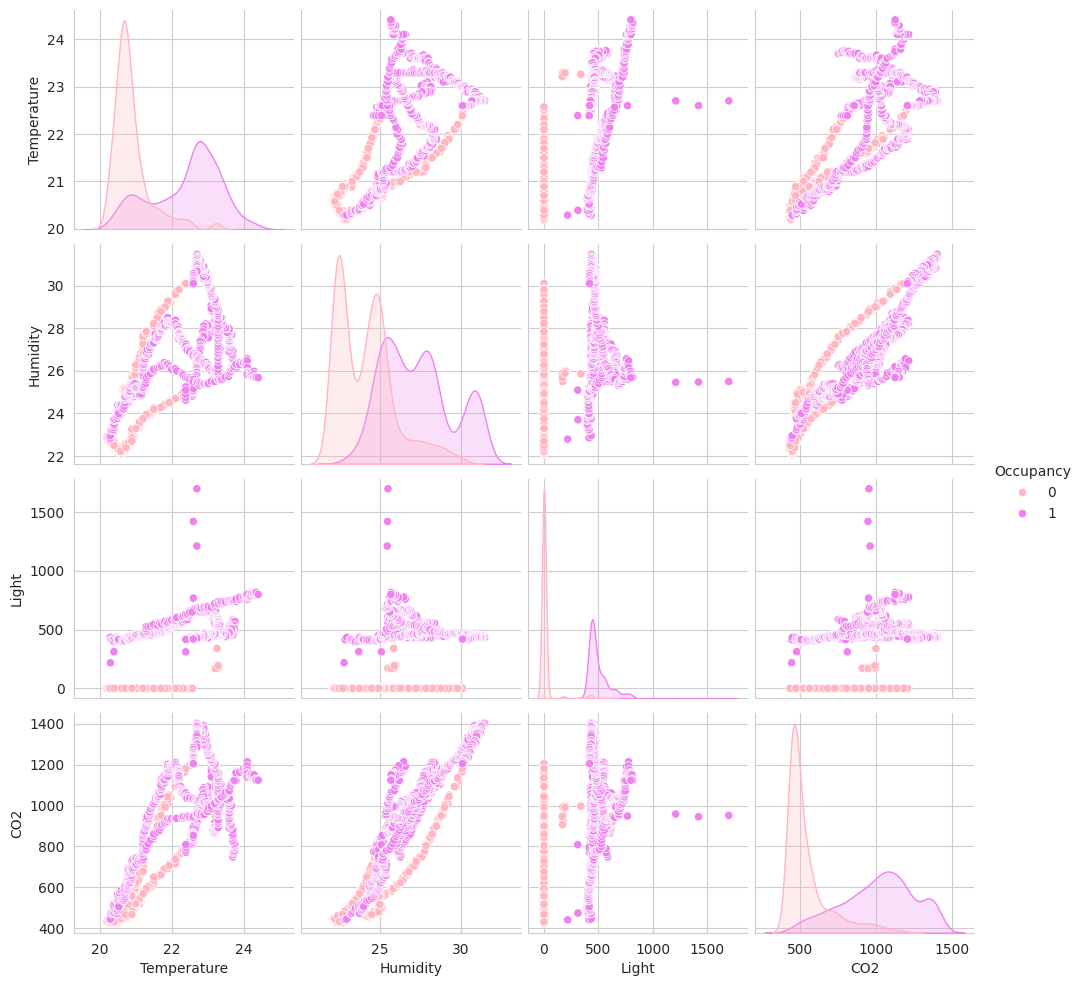

In [ ]:
# Pair plot of the features
custom_palette = ['lightpink', 'violet']
sns.pairplot(data, diag_kind='kde', hue='Occupancy', palette=custom_palette)

<Figure size 1400x800 with 0 Axes>

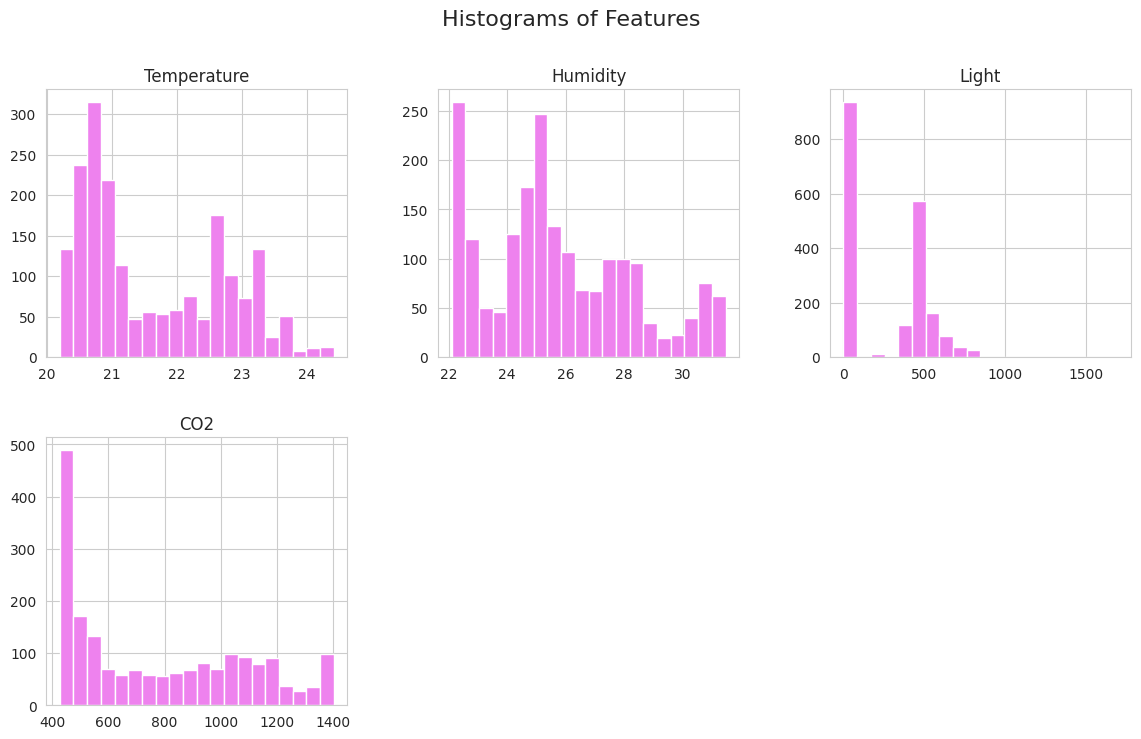

In [ ]:
# Histograms of the features
plt.figure(figsize=(14, 8))
data[['Temperature', 'Humidity', 'Light', 'CO2']].hist(bins=20, figsize=(14, 8), layout=(2, 3),color='violet')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()

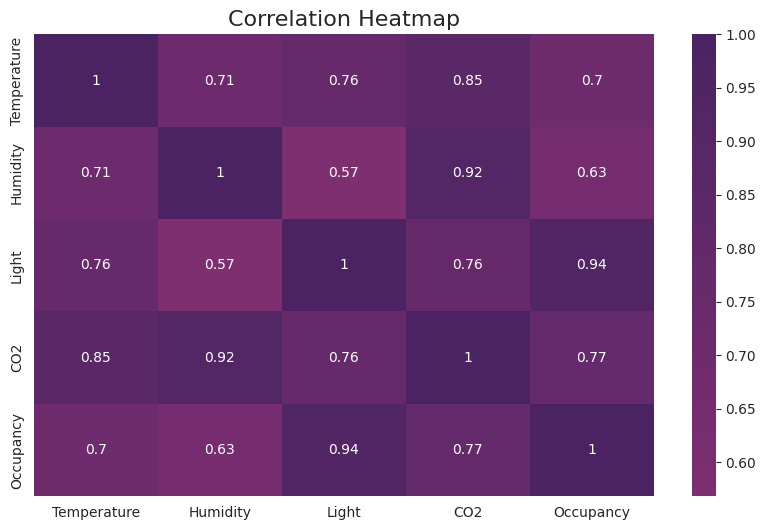

In [ ]:
plt.figure(figsize=(10, 6))
correlation_matrix = data[['Temperature', 'Humidity', 'Light', 'CO2', 'Occupancy']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='flare', center=0)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

# *Classification Using Support Vector Machine*

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Train SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)

In [ ]:
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [ ]:
y_pred = svm_classifier.predict(X_test)

In [ ]:
# Evaluate the SVM model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9845890410958904

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98       287
           1       0.97      1.00      0.99       297

    accuracy                           0.98       584
   macro avg       0.99      0.98      0.98       584
weighted avg       0.99      0.98      0.98       584


Confusion Matrix:
 [[278   9]
 [  0 297]]


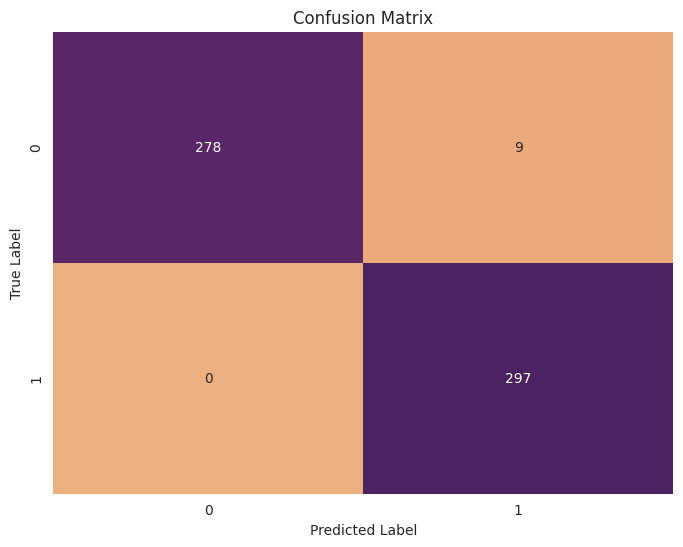

In [ ]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='flare', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

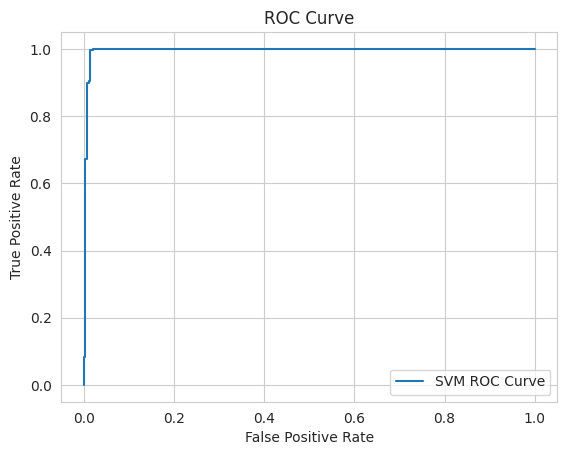

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, svm_classifier.decision_function(X_test))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot(label='SVM ROC Curve')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
# Print precision and accuracy
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Precision:", precision)
print("Accuracy:", accuracy)

Precision: 0.9705882352941176
Accuracy: 0.9845890410958904


# *Time Series Prediction Using Bi-LSTM*

In [ ]:
# Ensure data is sorted by Date for time series prediction
data.sort_values(by='Date', inplace=True)

In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Reshape data for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [ ]:
# Define and compile the Bi-LSTM model
model1 = Sequential()
model1.add(Bidirectional(LSTM(64, activation='relu', input_shape=(1, X_train_scaled.shape[1]))))
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the Bi-LSTM model
history1 = model1.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
39/39 [==============================] - 5s 26ms/step - loss: 0.6942 - accuracy: 0.4542 - val_loss: 0.6854 - val_accuracy: 0.7206
Epoch 2/50
39/39 [==============================] - 0s 8ms/step - loss: 0.6788 - accuracy: 0.8154 - val_loss: 0.6701 - val_accuracy: 0.8676
Epoch 3/50
39/39 [==============================] - 0s 8ms/step - loss: 0.6636 - accuracy: 0.8554 - val_loss: 0.6552 - val_accuracy: 0.8897
Epoch 4/50
39/39 [==============================] - 1s 16ms/step - loss: 0.6487 - accuracy: 0.8693 - val_loss: 0.6400 - val_accuracy: 0.8971
Epoch 5/50
39/39 [==============================] - 0s 11ms/step - loss: 0.6332 - accuracy: 0.8775 - val_loss: 0.6241 - val_accuracy: 0.9191
Epoch 6/50
39/39 [==============================] - 0s 5ms/step - loss: 0.6169 - accuracy: 0.8791 - val_loss: 0.6072 - val_accuracy: 0.9191
Epoch 7/50
39/39 [==============================] - 0s 5ms/step - loss: 0.5996 - accuracy: 0.8799 - val_loss: 0.5892 - val_accuracy: 0.9191
Epoch 8/50
39/39 

In [ ]:
# Evaluate the model on test data
loss, accuracy = model1.evaluate(X_test_reshaped, y_test, verbose=0)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Test Loss: 0.13413311541080475
Test Accuracy: 0.9640411138534546


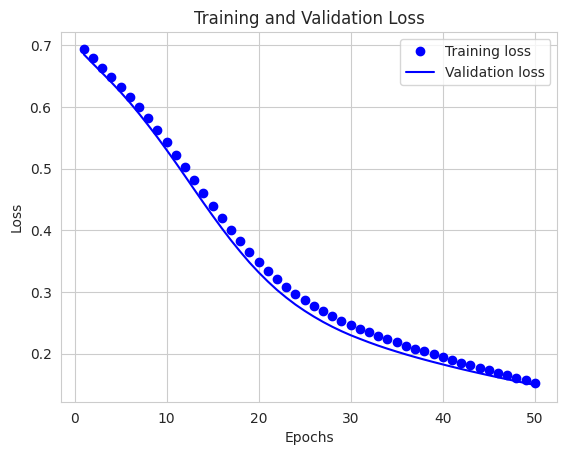

In [ ]:
# Get training and validation loss from the history object
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Create a range of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model2 = Sequential()
model2.add(Bidirectional(LSTM(64, activation='sigmoid', input_shape=(1, X_train_scaled.shape[1]))))
model2.add(Dense(1, activation='relu'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
39/39 [==============================] - 4s 16ms/step - loss: 7.6369 - accuracy: 0.5049 - val_loss: 7.8259 - val_accuracy: 0.4926
Epoch 2/50
39/39 [==============================] - 0s 5ms/step - loss: 7.6369 - accuracy: 0.5049 - val_loss: 7.8259 - val_accuracy: 0.4926
Epoch 3/50
39/39 [==============================] - 0s 5ms/step - loss: 7.6369 - accuracy: 0.5049 - val_loss: 7.8259 - val_accuracy: 0.4926
Epoch 4/50
39/39 [==============================] - 0s 5ms/step - loss: 7.6369 - accuracy: 0.5049 - val_loss: 7.8259 - val_accuracy: 0.4926
Epoch 5/50
39/39 [==============================] - 0s 5ms/step - loss: 7.6369 - accuracy: 0.5049 - val_loss: 7.8259 - val_accuracy: 0.4926
Epoch 6/50
39/39 [==============================] - 0s 5ms/step - loss: 7.6369 - accuracy: 0.5049 - val_loss: 7.8259 - val_accuracy: 0.4926
Epoch 7/50
39/39 [==============================] - 0s 5ms/step - loss: 7.6369 - accuracy: 0.5049 - val_loss: 7.8259 - val_accuracy: 0.4926
Epoch 8/50
39/39 [=

In [ ]:
loss, accuracy = model2.evaluate(X_test_reshaped, y_test, verbose=0)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Test Loss: 7.844536781311035
Test Accuracy: 0.4914383590221405


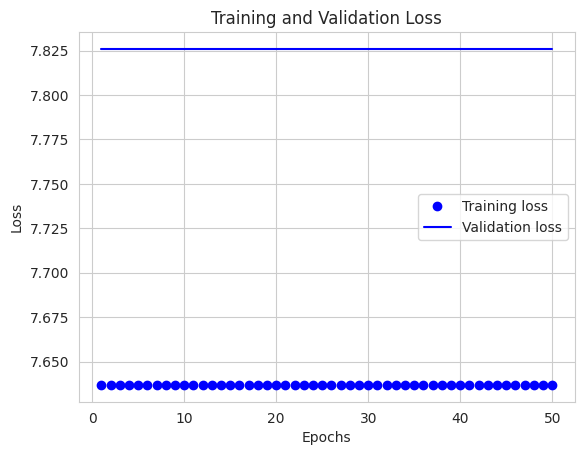

In [ ]:
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Create a range of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model3 = Sequential()
model3.add(Bidirectional(LSTM(48, activation='sigmoid', input_shape=(1, X_train_scaled.shape[1]))))
model3.add(Dense(1, activation='relu'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history3 = model3.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
39/39 [==============================] - 8s 23ms/step - loss: 7.6369 - accuracy: 0.5049 - val_loss: 7.8259 - val_accuracy: 0.4926
Epoch 2/50
39/39 [==============================] - 0s 6ms/step - loss: 7.6369 - accuracy: 0.5049 - val_loss: 7.8259 - val_accuracy: 0.4926
Epoch 3/50
39/39 [==============================] - 0s 5ms/step - loss: 7.6369 - accuracy: 0.5049 - val_loss: 7.8259 - val_accuracy: 0.4926
Epoch 4/50
39/39 [==============================] - 0s 5ms/step - loss: 7.6369 - accuracy: 0.5049 - val_loss: 7.8259 - val_accuracy: 0.4926
Epoch 5/50
39/39 [==============================] - 0s 5ms/step - loss: 7.6369 - accuracy: 0.5049 - val_loss: 7.8259 - val_accuracy: 0.4926
Epoch 6/50
39/39 [==============================] - 0s 5ms/step - loss: 7.6369 - accuracy: 0.5049 - val_loss: 7.8259 - val_accuracy: 0.4926
Epoch 7/50
39/39 [==============================] - 0s 5ms/step - loss: 7.6369 - accuracy: 0.5049 - val_loss: 7.8259 - val_accuracy: 0.4926
Epoch 8/50
39/39 [=

In [ ]:
loss, accuracy = model3.evaluate(X_test_reshaped, y_test, verbose=0)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Test Loss: 7.844536781311035
Test Accuracy: 0.4914383590221405


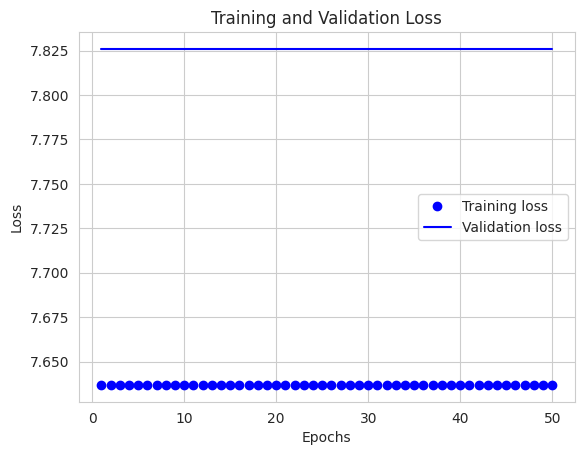

In [ ]:
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']

# Create a range of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model4 = Sequential()
model4.add(Bidirectional(LSTM(48, activation='relu', input_shape=(1, X_train_scaled.shape[1]))))
model4.add(Dense(1, activation='relu'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model4.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history4 = model4.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.15, verbose=1)

Epoch 1/50
37/37 [==============================] - 4s 17ms/step - loss: 4.5218 - accuracy: 0.5026 - val_loss: 4.3059 - val_accuracy: 0.5098
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 3.7736 - accuracy: 0.5026 - val_loss: 3.6312 - val_accuracy: 0.5098
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 3.2897 - accuracy: 0.5026 - val_loss: 3.1114 - val_accuracy: 0.5098
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 2.5170 - accuracy: 0.5026 - val_loss: 1.7635 - val_accuracy: 0.5098
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 1.6720 - accuracy: 0.5026 - val_loss: 1.5471 - val_accuracy: 0.5098
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 1.5206 - accuracy: 0.5026 - val_loss: 1.4748 - val_accuracy: 0.5098
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 1.4569 - accuracy: 0.5026 - val_loss: 1.4207 - val_accuracy: 0.5098
Epoch 8/50
37/37 [=

In [ ]:
loss, accuracy = model4.evaluate(X_test_reshaped, y_test, verbose=0)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Test Loss: 0.2664611339569092
Test Accuracy: 0.818493127822876


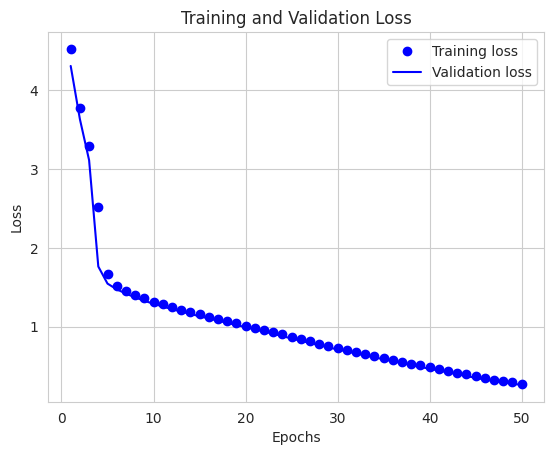

In [ ]:
train_loss = history4.history['loss']
val_loss = history4.history['val_loss']

# Create a range of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model5 = Sequential()
model5.add(Bidirectional(LSTM(48, activation='tanh', input_shape=(1, X_train_scaled.shape[1]))))
model5.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model5.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history5 = model5.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.15, verbose=1)

Epoch 1/50
37/37 [==============================] - 7s 41ms/step - loss: 0.6553 - accuracy: 0.9516 - val_loss: 0.6439 - val_accuracy: 0.9363
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6335 - accuracy: 0.9334 - val_loss: 0.6221 - val_accuracy: 0.9265
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6124 - accuracy: 0.9196 - val_loss: 0.6011 - val_accuracy: 0.9216
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.5921 - accuracy: 0.9135 - val_loss: 0.5804 - val_accuracy: 0.9216
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.5721 - accuracy: 0.9066 - val_loss: 0.5605 - val_accuracy: 0.9167
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.5528 - accuracy: 0.9040 - val_loss: 0.5412 - val_accuracy: 0.9167
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.5337 - accuracy: 0.9014 - val_loss: 0.5221 - val_accuracy: 0.9167
Epoch 8/50
37/37 [=

In [ ]:
loss, accuracy = model5.evaluate(X_test_reshaped, y_test, verbose=0)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Test Loss: 0.15716059505939484
Test Accuracy: 0.9554794430732727


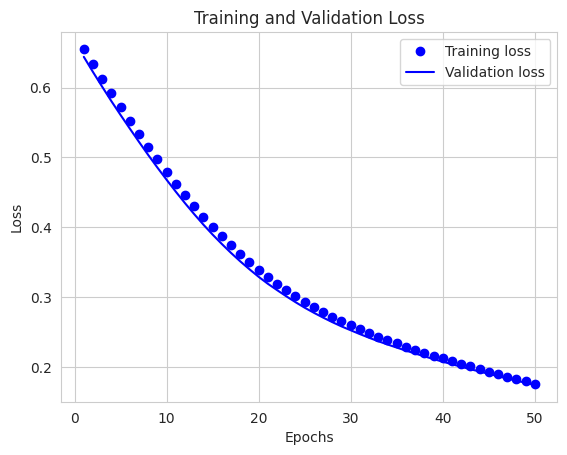

In [ ]:
train_loss = history5.history['loss']
val_loss = history5.history['val_loss']

# Create a range of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

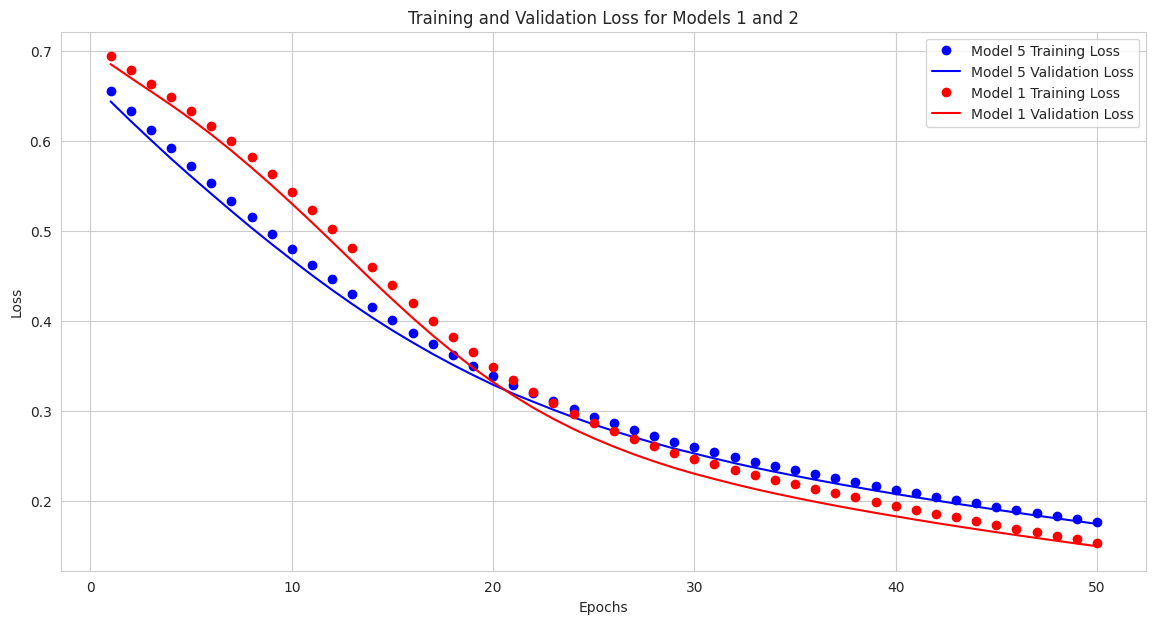

In [ ]:
# Get training and validation loss from history4 (Model 2)
train_loss4 = history5.history['loss']
val_loss4 = history5.history['val_loss']

# Create a range of epochs for Model 2
epochs4 = range(1, len(train_loss4) + 1)

# Plot training and validation loss for Model 2
plt.figure(figsize=(14, 7))
plt.plot(epochs4, train_loss4, 'bo', label='Model 5 Training Loss')
plt.plot(epochs4, val_loss4, 'b', label='Model 5 Validation Loss')

# Get training and validation loss from history (Model 1)
train_loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

# Create a range of epochs for Model 1
epochs1 = range(1, len(train_loss1) + 1)

# Plot training and validation loss for Model 1
plt.plot(epochs1, train_loss1, 'ro', label='Model 1 Training Loss')
plt.plot(epochs1, val_loss1, 'r', label='Model 1 Validation Loss')

# Add titles and labels
plt.title('Training and Validation Loss for Models 1 and 2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()